# Figure 5: Predict Fos <-> Behavior

This notebook uses hundreds of end-to-end model fits to predict neural measurents from behavioral and vice-versa. 

In [296]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import wandb

from fastprogress import progress_bar
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression

from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

In [158]:
NUM_BOOTSTRAP = 500
FOS_PARAM_DIR = "../results/bootstrap/fos"
BEHAVIOR_PARAM_DIR = "../results/bootstrap/behavior"
FOS_DATA_DIREC = "/Users/scott/Dropbox/Data/serotonin"
NUM_EPOCHS = 12
NUM_POSITIONS = 10
NUM_SYLLABLES = 50

## Load the data

In [91]:
drugs = np.load(os.path.join(FOS_DATA_DIREC, "drug_ids.npy"))
drugs

array([10,  2,  5,  4,  6,  5,  4,  3,  2,  4, 10,  6,  5,  7,  2,  3,  7,
       10,  1,  1,  8,  9,  7,  3,  3,  7,  1,  8,  9,  9,  1,  8,  2,  6,
        5,  4, 10,  9,  8,  7,  9,  3,  1,  5,  8,  6,  2,  4, 10, 10,  6,
        4,  2,  8,  7,  9,  3,  1,  5,  2,  4,  8,  6, 10,  1,  3,  5,  9,
        7,  7,  9,  1,  3,  5, 10,  2,  4,  8,  6,  5,  3,  7,  9,  1,  2,
        4,  8, 10,  6,  1,  3,  5,  7,  9,  4,  6,  8,  2, 10,  4,  6, 10,
        8,  2,  7,  9,  3,  5,  1,  6,  2, 10,  8,  4,  9,  7,  1,  3,  5,
        9,  1,  5,  3,  7, 10,  2,  4,  8,  7,  9,  3,  1,  5, 10,  8,  2,
        4,  6,  6,  8,  2,  4, 10,  1,  5,  3,  7,  9,  3, 10,  1,  2,  9,
       10,  8,  7,  6,  4,  4,  5,  7,  9,  3,  8,  1,  6,  5,  2])

In [88]:
def load_fos_counts(left_trunc=8):
    data = np.load(os.path.join(FOS_DATA_DIREC, f"downsampled_data_4.npz"))
    intensity_3d = data["intensity"][:-1]
    counts_3d = data["counts"][:-1]
    mouse_inds = data["mouse_inds"]
    assert intensity_3d.shape[0] == 168
    assert counts_3d.shape[0] == 168

    counts_3d = counts_3d[:, left_trunc:, :, :]
    intensity_3d = intensity_3d[:, left_trunc:, :, :]
    print(counts_3d.shape)

    alive_voxels = np.sum(counts_3d, axis=0) > 0
    print(alive_voxels.sum(), "/", np.prod(intensity_3d.shape[1:]), "voxels are 'alive'")

    intensity = intensity_3d[:, alive_voxels]
    counts = counts_3d[:, alive_voxels]
    intensity[counts == 0] = np.nan

    return counts, intensity, alive_voxels

fos_counts, _, alive_voxels = load_fos_counts()


(168, 81, 95, 80)
348766 / 615600 voxels are 'alive'


(<Axes: >, <matplotlib.image.AxesImage at 0x35f3ed9f0>)

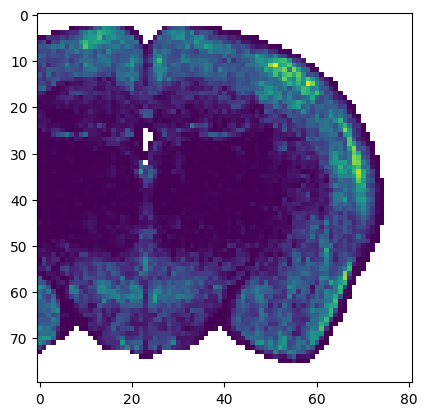

In [89]:
def plot_coronal(flat_array, y_idx, alive_voxels, ax=None, **kwargs):
    arr = np.nan * np.zeros(alive_voxels.shape)
    arr[alive_voxels] = flat_array

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr[:, y_idx, :].T, **kwargs)
    return ax, im

# plot_coronal(intensity[100], 50)
plot_coronal(fos_counts[100], 50, alive_voxels)


## Load the final model fits

In [170]:
final_fos_params = loadmat(os.path.join(FOS_DATA_DIREC, "2023_11_01_params.mat"))
final_fos_params.keys()

dict_keys(['__header__', '__version__', '__globals__', 'factors', 'count_loadings', 'count_row_effects', 'count_col_effects', 'intensity_loadings', 'intensity_row_effects', 'intensity_col_effects', 'intensity_variance'])

In [174]:
# Rename keys as necessary
final_behav_params = loadmat(os.path.join(FOS_DATA_DIREC, "dirichlet_tucker_22_4_4_22.mat"))
final_behav_params['core_tensor'] = final_behav_params['G']
final_behav_params['epoch_factors'] = final_behav_params['E']
final_behav_params['position_factors'] = final_behav_params['P']
final_behav_params['syllable_factors'] = final_behav_params['S']
final_behav_params['loadings'] = final_behav_params['W']

## Download the bootstrap model fits from W&B

This takes about 10 minutes the first time you run it, but then the files are saved on your hard drive.

In [56]:
# download the parameters of the Fos semiNMF fits
api = wandb.Api()
for i in progress_bar(range(0, NUM_BOOTSTRAP)):
    if os.path.exists(os.path.join(FOS_PARAM_DIR, "params_{:04d}.pkl".format(i))):
        # print(f"found results for iteration {i}")
        continue

    artifact = api.artifact("linderman-lab/serotonin-fos-seminmf-bootstrap/params_pkl:v{:d}".format(i))
    artifact.download(root=FOS_PARAM_DIR)

In [57]:
# download the parameters of the Fos semiNMF fits
api = wandb.Api()
for i in progress_bar(range(0, NUM_BOOTSTRAP + 3)):
    if os.path.exists(os.path.join(BEHAVIOR_PARAM_DIR, "params_{:04d}.pkl".format(i))):
        # print(f"found results for iteration {i}")
        continue

    try:
        artifact = api.artifact("linderman-lab/serotonin-behavior-bootstrap/params_pkl:v{:d}".format(i))
        artifact.download(root=BEHAVIOR_PARAM_DIR)
    except: 
        print("could not find artifact params_pkl:v{:d}".format(i))
        continue

## Fos -> behavior predictions

In [149]:
def predict_behavior_given_fos(test_fos_counts,
                               train_fos_counts, 
                               fos_params,
                               beh_params):
    """Predict behavioral syllables (across time and space) given 
    test Fos counts.
    """
    if test_fos_counts.ndim == 1:
        is_1d = True
        test_fos_counts = test_fos_counts[None, :]
    else:
        is_1d = False
        assert test_fos_counts.ndim == 2

    fos_mean = train_fos_counts.mean(axis=0)
    fos_var = train_fos_counts.var(axis=0)
    test_fos_centered = test_fos_counts - fos_mean
    
    # Compute the OLS estimate of the fos factors given test fos counts
    fos_loadings = fos_params['count_loadings']            # (mice x n_fos_factors) 
    fos_factors = fos_params['factors'].T                  # (voxels x n_fos_factors)
    fos_loading_cov = np.cov(fos_loadings, rowvar=False)   # (n_fos_factors x n_fos_factors)
    pred_fos_loadings = np.linalg.solve(
        (fos_factors.T / fos_var) @ fos_factors, 
        (fos_factors.T / fos_var) @ test_fos_centered.T).T   # (n_fos_factors, n_pred)
    
    # Train a linear regression to map fos loadings to (unconstrained) behavior loadings
    beh_loadings = beh_params['loadings']          # (mice x n_beh_factors) 
    beh_loadings_unc = tfb.SoftmaxCentered().inverse(beh_loadings)
    lr = LinearRegression()
    lr.fit(fos_loadings, beh_loadings_unc)
    pred_beh_loadings = tfb.SoftmaxCentered()(lr.predict(pred_fos_loadings))

    # Map predicted behavior loadings to predicted syllable counts
    pred_beh = np.einsum('pi,ijkl, mj, kn, lo->pmno', 
                         pred_beh_loadings, 
                         beh_params['core_tensor'], 
                         beh_params['epoch_factors'], 
                         beh_params['position_factors'], 
                         beh_params['syllable_factors'])
    
    return pred_beh[0] if is_1d else pred_beh

In [150]:
def make_fos_mask(region, alive_voxels):
    """Make a binary mask for perturbing fos counts
    """
    region_ids = loadmat(os.path.join(FOS_DATA_DIREC, "region_ids_100um.mat"))["regions_small"]
    region_ids = np.transpose(region_ids, (2,1,0))
    region_ids_alive = region_ids[alive_voxels]

    annot = pd.read_csv(os.path.join(FOS_DATA_DIREC, "region_annotations.csv"))
    target_id = annot[annot["name"] == region].id.values[0]
    mask = region_ids_alive == target_id
    return mask

([], [])

<Figure size 640x480 with 0 Axes>

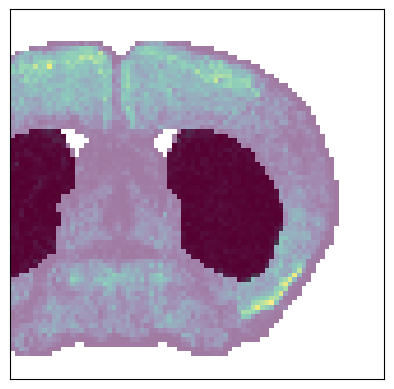

In [151]:
mask  = make_fos_mask("Caudoputamen", alive_voxels)
# mask  = make_fos_mask("Central amygdalar nucleus", alive_voxels)
# mask  = make_fos_mask("Primary motor area", alive_voxels)
# mask  = make_fos_mask("Dentate nucleus", alive_voxels)

plt.figure()
slc = 35
ax, im = plot_coronal(fos_counts[100], slc, alive_voxels)
ax, im = plot_coronal(mask, slc, alive_voxels, ax=ax, alpha=0.5, cmap="Reds")
plt.xticks([])
plt.yticks([])

In [260]:
# Make a pair of test fos maps to predict behavior from
saline_fos_counts = fos_counts[drugs == 10].mean(axis=0)
test_fos_counts = np.row_stack([
    saline_fos_counts,
    saline_fos_counts + 100 * mask
])


### Compute distribution of predicted change in behavior using final model fits

In [326]:
# score_fn = lambda x, x0: np.log(x / x0) # log relative change in probability
score_fn = lambda x, x0: (x - x0)       # absolute change in probability


In [327]:
final_pred_beh = predict_behavior_given_fos(
    test_fos_counts,
    fos_counts, 
    final_fos_params,
    final_behav_params
)
final_pred_beh_change = score_fn(final_pred_beh[1], final_pred_beh[0])

/Users/scott/anaconda3/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:289: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


### Compute distribution of predicted change in behavior across bootstrap replicates

In [328]:
bootstrap_pred_beh_changes = np.zeros((NUM_BOOTSTRAP, NUM_EPOCHS, NUM_POSITIONS, NUM_SYLLABLES))
for i in progress_bar(range(500)):
    fname = "params_{:04d}.pkl".format(i)
    with open(os.path.join(FOS_PARAM_DIR, fname), "rb") as f:
        fos_params = pickle.load(f)

    with open(os.path.join(BEHAVIOR_PARAM_DIR, fname), "rb") as f:
        behav_params = pickle.load(f)

    assert np.all(behav_params['bootstrap_inds'] == fos_params['bootstrap_inds'])

    pred_beh = predict_behavior_given_fos(
        test_fos_counts,
        fos_counts, 
        fos_params,
        behav_params
    )
    bootstrap_pred_beh_changes[i] = score_fn(pred_beh[1], pred_beh[0])

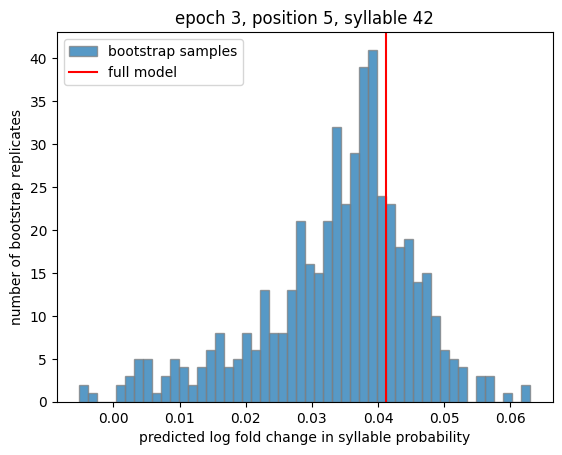

In [329]:
e, p, s = 3, 5, 42
plt.hist(bootstrap_pred_beh_changes[:, e, p, s], 50, alpha=0.75, edgecolor='gray', label='bootstrap samples')
plt.axvline(final_pred_beh_change[e, p, s], color='r', label='full model')
plt.xlabel("predicted log fold change in syllable probability")
plt.ylabel("number of bootstrap replicates")
plt.title(f"epoch {e}, position {p}, syllable {s}")
plt.legend()

### Compute quantile of zero

Text(0, 0.5, 'count')

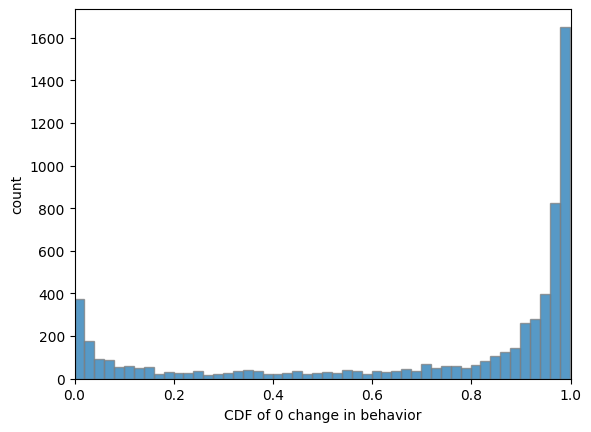

In [330]:
cdf0 = np.sum(bootstrap_pred_beh_changes < 0, axis=0) / (NUM_BOOTSTRAP + 1)

plt.hist(cdf0.ravel(), 50, alpha=0.75, edgecolor='gray', label='bootstrap samples')
plt.xlim(0, 1)
plt.xlabel("CDF of 0 change in behavior")
plt.ylabel("count")

### Visualize only the significant changes

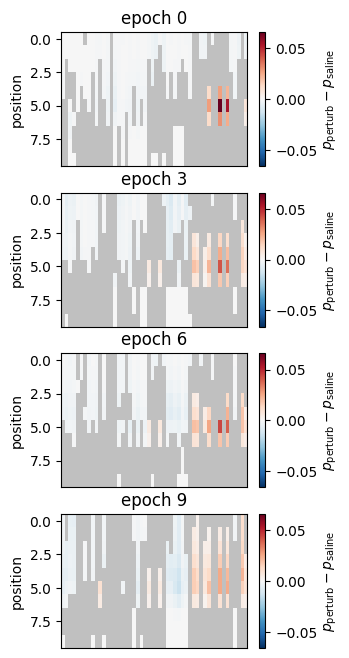

In [334]:
# Determine significance
thr = 0
sig = (cdf0 < 0.025) | (cdf0 > 0.975) & (abs(final_pred_beh_change) > thr)

# Make a copy of the changes and nan out the insignificant ones
sig_pred_beh_change = final_pred_beh_change.copy()
sig_pred_beh_change[~sig] = np.nan

# Make a colormap to hide insignificant changes
cmap = cm.RdBu_r
cmap.set_bad('k', alpha=0.25)

# Plot the changes for a few epochs
epochs_to_plot = [0, 3, 6, 9]
fig, axs = plt.subplots(len(epochs_to_plot), figsize=(3, 2 * len(epochs_to_plot)))
vlim = np.nanmax(abs(sig_pred_beh_change))
for j, e in enumerate(epochs_to_plot):
    im = axs[j].imshow(sig_pred_beh_change[e], 
                       cmap=cmap,
                       interpolation="none", 
                       aspect="auto",
                       vmin=-vlim, 
                       vmax=vlim)
    axs[j].set_ylabel("position")
    axs[j].set_xticks([])
    axs[j].set_title(f"epoch {e}")
    # plt.colorbar(im, label=r"$\log \frac{{p_{{\mathsf{{perturb}}}}}}{{p_{{\mathsf{{saline}}}}}}$.")
    plt.colorbar(im, label=r"$p_{{\mathsf{{perturb}}}} - p_{{\mathsf{{saline}}}}$")

### Visualize all predictions for comparison

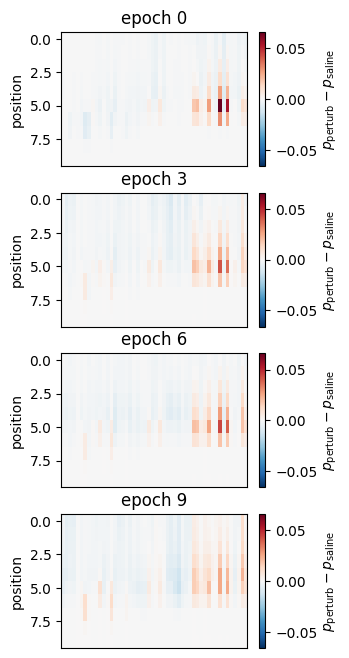

In [335]:
# Make a copy of the changes and nan out the insignificant ones
sig_pred_beh_change = final_pred_beh_change.copy()

# Make a colormap to hide insignificant changes
cmap = cm.RdBu_r
cmap.set_bad('k', alpha=0.25)

# Plot the changes for a few epochs
epochs_to_plot = [0, 3, 6, 9]
fig, axs = plt.subplots(len(epochs_to_plot), figsize=(3, 2 * len(epochs_to_plot)))
vlim = np.nanmax(abs(sig_pred_beh_change))
for j, e in enumerate(epochs_to_plot):
    im = axs[j].imshow(sig_pred_beh_change[e], 
                       cmap=cmap,
                       interpolation="none", 
                       aspect="auto",
                       vmin=-vlim, 
                       vmax=vlim)
    axs[j].set_ylabel("position")
    axs[j].set_xticks([])
    axs[j].set_title(f"epoch {e}")
    # plt.colorbar(im, label=r"fold change in prob.")
    plt.colorbar(im, label=r"$p_{{\mathsf{{perturb}}}} - p_{{\mathsf{{saline}}}}$")

## Next Steps

- Add the behavior to Fos predictions, using the same bootstrap samples
- Maybe: p-values for each prediction and FDR control